# 11_2_LEARN-DataAnalysisML

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/11_2_LEARN_DataAnalysisML.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [28]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt


In [29]:
# cloning the data repo
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


## 1. Setup H2O AutoML

In [4]:
%%capture 
!pip install h2o

In [5]:
import h2o
from h2o.automl import H2OAutoML

In [6]:
# If this doesnt work - install java. 
# Start the H2O cluster (locally)
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323 . connected.


H2O_cluster_uptime:,2 mins 37 secs
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,4 months and 15 days !!!
H2O_cluster_name:,H2O_from_python_lucaslevassor_1hz50e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.242 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### 1.1 Import our dataframe as h20 object

Train a model based on the target and the df

In [30]:
first_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_1st_iteration_all_analytics.csv')
first_input_for_ml 

,Unnamed: 0,Line_name,0,1,2,3,norm_strict_x,norm_strict_y,norm_strict_mean
0,0,yp49_A01,1,2,5,1,0.972701,1.796170,1.384435
1,1,yp49_C01,1,2,5,9,0.536658,0.738584,0.637621
2,2,yp49_D01,2,4,7,3,0.175896,0.109680,0.142788
3,3,yp49_E01,2,1,5,7,0.345201,0.228028,0.286614
4,4,yp49_F01,3,3,6,1,26.416324,23.762944,25.089634
...,...,...,...,...,...,...,...,...,...
164,164,yp51_C12,8,3,7,2,0.000000,0.089923,0.044961
165,165,yp51_D12,8,2,7,6,0.614962,1.264863,0.939912
166,166,yp51_E12,8,1,6,10,0.466688,2.068186,1.267437
167,167,yp50_F05,6,1,8,2,15.155009,12.813656,13.984332


### 1.2 Investigate how the predictions from the previous ML cycle mathced the sampled strains 

In [31]:
# Run ML with new input 
second_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_2nd_iteration_all_analytics.csv')
second_input_for_ml = second_input_for_ml[['Line_name',  '0','1','2','3','norm_strict_x',	'norm_strict_y',	'norm_strict_mean']]
second_input_for_ml.columns = ['Line_name', '0','1','2','3','norm_strict_x',	'norm_strict_y',	'norm_strict_mean']

In [32]:
list_of_promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}


g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]

pg8h_list_of_index = ['CYC1', 'ENO2']
pcpr_list_of_index = ['CCW12', 'TPI1'] 



g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in second_input_for_ml.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

second_input_for_ml['G8H'] = g8h_genotype
second_input_for_ml['CPR'] = cpr_genotype
second_input_for_ml['pG8H'] = pg8h_genotype
second_input_for_ml['pCPR'] = pcpr_genotype
second_input_for_ml

,Line_name,0,1,2,3,norm_strict_x,norm_strict_y,norm_strict_mean,G8H,CPR,pG8H,pCPR
0,yp53_A01,4,1,5,2,9.058562,5.196491,7.127526,Vmin,Aan,CYC1,CCW12
1,yp53_A02,4,1,5,2,28.175952,16.525934,22.350943,Vmin,Aan,CYC1,CCW12
2,yp53_A04,4,2,5,2,80.375862,66.154223,73.265043,Vmin,Aan,ENO2,CCW12
3,yp53_A06,5,1,5,2,121.767572,107.215440,114.491506,Smus,Aan,CYC1,CCW12
4,yp53_A07,5,2,6,2,159.059724,144.151010,151.605367,Smus,Aan,ENO2,TPI1
...,...,...,...,...,...,...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,15.322951,13.201487,14.262219,Vmin,Cro,CYC1,TPI1
125,yp54_C04,5,2,6,3,94.318358,71.892536,83.105447,Smus,Ara,ENO2,TPI1
126,yp54_C09,3,1,6,3,46.469517,29.678034,38.073775,Cro,Ara,CYC1,TPI1
127,yp54_D12,5,1,6,6,3.718051,1.356013,2.537032,Smus,Ahu,CYC1,TPI1


In [33]:
second_input_for_ml["Names"] = second_input_for_ml[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
second_input_for_ml =second_input_for_ml[['Names', 'norm_strict_x',	'norm_strict_y',	'norm_strict_mean']]
second_input_for_ml

,Names,norm_strict_x,norm_strict_y,norm_strict_mean
0,Vmin-CYC1-CCW12-Aan,9.058562,5.196491,7.127526
1,Vmin-CYC1-CCW12-Aan,28.175952,16.525934,22.350943
2,Vmin-ENO2-CCW12-Aan,80.375862,66.154223,73.265043
3,Smus-CYC1-CCW12-Aan,121.767572,107.215440,114.491506
4,Smus-ENO2-TPI1-Aan,159.059724,144.151010,151.605367
...,...,...,...,...
124,Vmin-CYC1-TPI1-Cro,15.322951,13.201487,14.262219
125,Smus-ENO2-TPI1-Ara,94.318358,71.892536,83.105447
126,Cro-CYC1-TPI1-Ara,46.469517,29.678034,38.073775
127,Smus-CYC1-TPI1-Ahu,3.718051,1.356013,2.537032


In [34]:
first_round_top_producers = pd.read_csv('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL1/predicted_unseen_comb_ML1_trained_on_1st_analytics".csv')
first_round_top_producers = first_round_top_producers.sort_values(by='Predicted_strict_production', ascending=False)

first_round_top_producers["Names"] = first_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
first_round_top_producers  = first_round_top_producers[['Names', 'Predicted_strict_production']]
#first_round_top_producers['Predicted_strict_production_rank_pct']= first_round_top_producers['Predicted_strict_production'].rank(pct=True)
first_round_top_producers

,Names,Predicted_strict_production
0,Smus-ENO2-TPI1-Rse,169.288180
1,Rsep-ENO2-TPI1-Ara,162.151856
2,Smus-ENO2-CCW12-Ara,161.904255
3,Smus-CYC1-TPI1-Ara,157.638727
4,Smus-ENO2-TPI1-Aan,156.976470
...,...,...
1114,Rsep-CYC1-TPI1-Ani,-9.125477
1115,Ccal-ENO2-TPI1-Cac,-12.768510
1116,Rsep-PCK1-CCW12-Ara,-12.901417
1117,Ccal-ENO2-CCW12-Cac,-16.241411


In [36]:
predicted_vs_sampled = pd.merge(first_round_top_producers, second_input_for_ml, on=['Names'])
predicted_vs_sampled['norm_strict_measured_rank'] = predicted_vs_sampled['norm_strict_mean'].rank()
predicted_vs_sampled['Predicted_strict_production_rank_pct'] = predicted_vs_sampled['Predicted_strict_production'].rank()


#new_input_for_ml['NA_bottom'] = new_input_for_ml['norm_strict_mean'].rank(na_option='bottom')
#new_input_for_ml['pct_rank'] = new_input_for_ml['norm_strict_mean'].rank(pct=True)
predicted_vs_sampled = predicted_vs_sampled.sort_values(by= 'norm_strict_mean', ascending = False)
predicted_vs_sampled

,Names,Predicted_strict_production,norm_strict_x,norm_strict_y,norm_strict_mean,norm_strict_measured_rank,Predicted_strict_production_rank_pct
4,Smus-ENO2-TPI1-Aan,156.976470,159.059724,144.151010,151.605367,113.0,109.0
11,Rsep-ENO2-TPI1-Clo,103.496648,126.638026,173.503553,150.070790,112.0,102.5
10,Rsep-ENO2-TPI1-Clo,103.496648,159.517718,138.064072,148.790895,111.0,102.5
31,Smus-CYC1-CCW12-Clo,57.162466,143.483630,142.685448,143.084539,110.0,82.0
32,Cro-ENO2-TPI1-Cro,56.438602,138.267757,145.587886,141.927821,109.0,80.5
...,...,...,...,...,...,...,...
107,Oeu-CYC1-TPI1-Ahu,-0.554845,0.000000,0.000000,0.000000,4.0,6.0
108,Rsep-CYC1-TPI1-Ahu,-2.421277,0.000000,0.000000,0.000000,4.0,5.0
99,Smus-CYC1-TPI1-Ahu,2.649671,0.000000,0.000000,0.000000,4.0,14.0
98,Smus-CYC1-TPI1-Ahu,2.649671,0.000000,0.000000,0.000000,4.0,14.0


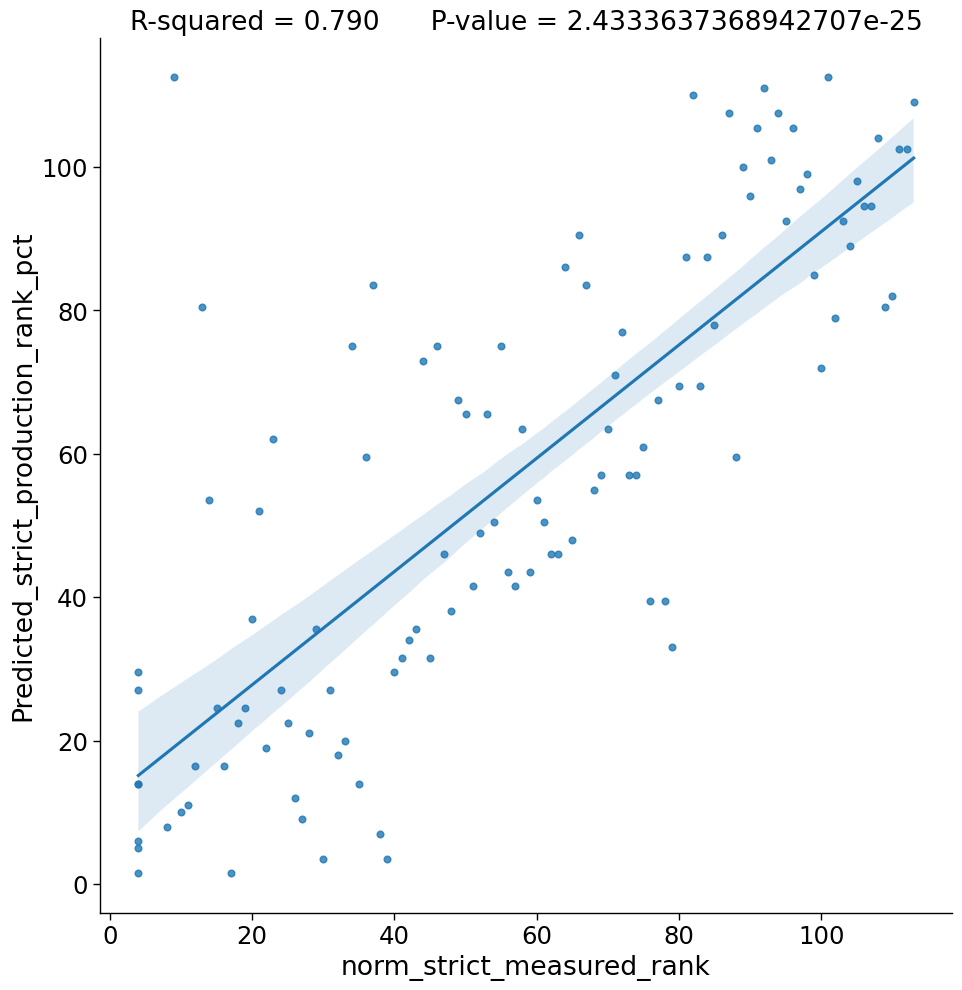

In [37]:
import seaborn as sns
from scipy.stats import pearsonr
import scipy as sp
from scipy import stats

#set seaborn plotting aesthetics as default
sns.set_context("paper", font_scale=2.0, rc={"lines.linewidth": 1.5})

g = sns.lmplot(data=predicted_vs_sampled, x="norm_strict_measured_rank", y="Predicted_strict_production_rank_pct",  palette="viridis", fit_reg = True, height=10)
r, p = stats.pearsonr(predicted_vs_sampled['norm_strict_measured_rank'], predicted_vs_sampled['Predicted_strict_production_rank_pct'])


ax = plt.gca()
ax.set_title(f"R-squared = {r:.3f}      P-value = {p}")

name = 'predicted_vs_tested_corr_RANKED_merged_analytics"'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)



### 1.3 Merging the dataframes for updating the model 

In [114]:
new_input_for_ml = pd.concat([first_input_for_ml,second_input_for_ml ])
new_input_for_ml

,Unnamed: 0,Line_name,0,1,2,3,norm_strict_x,norm_strict_y,norm_strict_mean,Names
0,0.0,yp49_A01,1.0,2.0,5.0,1.0,0.972701,1.796170,1.384435,NaN
1,1.0,yp49_C01,1.0,2.0,5.0,9.0,0.536658,0.738584,0.637621,NaN
2,2.0,yp49_D01,2.0,4.0,7.0,3.0,0.175896,0.109680,0.142788,NaN
3,3.0,yp49_E01,2.0,1.0,5.0,7.0,0.345201,0.228028,0.286614,NaN
4,4.0,yp49_F01,3.0,3.0,6.0,1.0,26.416324,23.762944,25.089634,NaN
...,...,...,...,...,...,...,...,...,...,...
124,NaN,NaN,NaN,NaN,NaN,NaN,15.322951,13.201487,14.262219,Vmin-CYC1-TPI1-Cro
125,NaN,NaN,NaN,NaN,NaN,NaN,94.318358,71.892536,83.105447,Smus-ENO2-TPI1-Ara
126,NaN,NaN,NaN,NaN,NaN,NaN,46.469517,29.678034,38.073775,Cro-CYC1-TPI1-Ara
127,NaN,NaN,NaN,NaN,NaN,NaN,3.718051,1.356013,2.537032,Smus-CYC1-TPI1-Ahu


In [115]:
new_input_for_ml['default_rank'] = new_input_for_ml['norm_strict_mean'].rank()
new_input_for_ml['max_rank'] = new_input_for_ml['norm_strict_mean'].rank(method='max')
new_input_for_ml['NA_bottom'] = new_input_for_ml['norm_strict_mean'].rank(na_option='bottom')
new_input_for_ml['pct_rank'] = new_input_for_ml['norm_strict_mean'].rank(pct=True)
new_input_for_ml = new_input_for_ml.sort_values(by= 'NA_bottom', ascending = False)

new_input_for_ml

,Unnamed: 0,Line_name,0,1,2,3,norm_strict_x,norm_strict_y,norm_strict_mean,Names,default_rank,max_rank,NA_bottom,pct_rank
75,75.0,yp50_D03,5.0,2.0,6.0,3.0,277.307816,124.097492,200.702654,NaN,298.0,298.0,298.0,1.000000
21,21.0,yp49_F04,3.0,2.0,6.0,2.0,138.940568,173.866982,156.403775,NaN,297.0,297.0,297.0,0.996644
42,NaN,NaN,NaN,NaN,NaN,NaN,145.152656,163.941847,154.547251,Rsep-ENO2-TPI1-Rse,296.0,296.0,296.0,0.993289
4,NaN,NaN,NaN,NaN,NaN,NaN,159.059724,144.151010,151.605367,Smus-ENO2-TPI1-Aan,295.0,295.0,295.0,0.989933
27,NaN,NaN,NaN,NaN,NaN,NaN,126.638026,173.503553,150.070790,Rsep-ENO2-TPI1-Clo,294.0,294.0,294.0,0.986577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Smus-CYC1-TPI1-Ahu,13.0,25.0,13.0,0.043624
105,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Smus-CYC1-TPI1-Ahu,13.0,25.0,13.0,0.043624
26,26.0,yp49_E05,2.0,3.0,7.0,8.0,0.000000,0.000000,0.000000,NaN,13.0,25.0,13.0,0.043624
108,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Rsep-CYC1-TPI1-Ahu,13.0,25.0,13.0,0.043624


### 1.2 Update dataframe Change 

In [116]:
new_input_for_ml = new_input_for_ml[['Line_name', '0','1','2','3','norm_strict_x']]
new_input_for_ml.columns = ['Line_name', '0','1','2','3','Amt_norm']
new_input_for_ml

,Line_name,0,1,2,3,Amt_norm
75,yp50_D03,5.0,2.0,6.0,3.0,277.307816
21,yp49_F04,3.0,2.0,6.0,2.0,138.940568
42,NaN,NaN,NaN,NaN,NaN,145.152656
4,NaN,NaN,NaN,NaN,NaN,159.059724
27,NaN,NaN,NaN,NaN,NaN,126.638026
...,...,...,...,...,...,...
104,NaN,NaN,NaN,NaN,NaN,0.000000
105,NaN,NaN,NaN,NaN,NaN,0.000000
26,yp49_E05,2.0,3.0,7.0,8.0,0.000000
108,NaN,NaN,NaN,NaN,NaN,0.000000


In [11]:
df_test = h2o.H2OFrame(pd.concat([new_input_for_ml], axis='columns'))
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Rows:298
Cols:6




,Line_name,0,1,2,3,Amt_norm
type,string,int,int,int,int,real
mins,NaN,1.0,1.0,5.0,1.0,0.0
mean,NaN,4.761744966442952,2.144295302013422,6.137583892617449,4.758389261744967,28.932462303045384
maxs,NaN,8.0,4.0,8.0,10.0,277.3078163064027
sigma,NaN,1.9454547672041116,1.1113059960605862,1.0530684048668946,2.586291253376485,46.060107369420486
zeros,0,0,0,0,0,72
missing,0,0,0,0,0,0
0,yp50_D03,5.0,2.0,6.0,3.0,277.3078163064027
1,yp49_F04,3.0,2.0,6.0,2.0,138.940567699116
2,yp53_E02,6.0,2.0,6.0,5.0,145.15265551287143


In [12]:
# Since the data is categorical we need to make it from numerical to categorical 
df_test['0']= df_test['0'].asfactor()
df_test['1']= df_test['1'].asfactor()
df_test['2'] = df_test['2'].asfactor()
df_test['3'] = df_test['3'].asfactor()

In [13]:
df_test.describe()

Rows:298
Cols:6




,Line_name,0,1,2,3,Amt_norm
type,string,enum,enum,enum,enum,real
mins,NaN,,,,,0.0
mean,NaN,,,,,28.932462303045384
maxs,NaN,,,,,277.3078163064027
sigma,NaN,,,,,46.060107369420486
zeros,0,,,,,72
missing,0,0,0,0,0,0
0,yp50_D03,5,2,6,3,277.3078163064027
1,yp49_F04,3,2,6,2,138.940567699116
2,yp53_E02,6,2,6,5,145.15265551287143


Set some arguments for the autoML. 


Important here is that we dont split the dataset but rather keep the cross-validation validate a model internally, i.e., estimate the model performance without having to sacrifice a validation split. See: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html


## 2 RUN automl

Here we are defining the autoML object and after we can train it

In [14]:
# Select the columns we want to train on
feature_cols = ['0', '1', '2', '3']

# Initialize H2O autoML class
AutoML = H2OAutoML(
    max_runtime_secs=0,  # 1 hour =int(3600 * 1) , if unlimited time is wanted then set this to zero = 0
    max_models=None,  # None =  no limit
    nfolds=5,         # number of folds for k-fold cross-validation (nfolds=0 disables cross-validation)
    seed=1,            # Reproducibility
    exclude_algos = ["StackedEnsemble"],
    sort_metric = "MAE",
    keep_cross_validation_predictions=True 
)

Train a model based on the target and the df. 


It has been Commented out and saved as showed below

In [15]:
%%time

AutoML.train(
     x=feature_cols,
     y='Amt_norm',
     training_frame=df_test,
 )


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 35.4 s, sys: 2.66 s, total: 38 s
Wall time: 1h 7s
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_1_20221122_130912_model_292


Model Summary: 


,,number_of_trees
0,,55.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 416.0249461903503
RMSE: 20.396689589008073
MAE: 9.07783203343345
RMSLE: NaN
Mean Residual Deviance: 416.0249461903503

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 664.8690275935352
RMSE: 25.785054345367108
MAE: 13.305811876781917
RMSLE: NaN
Mean Residual Deviance: 664.8690275935352

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,13.294589,3.359004,17.475672,11.786045,13.966435,14.731307,8.513488
1,mean_residual_deviance,663.185900,430.733730,1362.629500,461.437650,667.056950,620.252600,204.552860
2,mse,663.185900,430.733730,1362.629500,461.437650,667.056950,620.252600,204.552860
3,r2,0.701595,0.142577,0.511693,0.790198,0.619081,0.710746,0.876259
4,residual_deviance,663.185900,430.733730,1362.629500,461.437650,667.056950,620.252600,204.552860
5,rmse,24.685884,8.200075,36.913810,21.481100,25.827446,24.904871,14.302197
6,rmsle,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-11-22 13:10:14,49.835 sec,0.0,54.063104,28.710615,2922.819172
1,,2022-11-22 13:10:14,49.839 sec,5.0,37.957260,19.345117,1440.753602
2,,2022-11-22 13:10:14,49.843 sec,10.0,30.719387,15.531919,943.680750
3,,2022-11-22 13:10:14,49.848 sec,15.0,27.007791,13.378235,729.420790
4,,2022-11-22 13:10:14,49.852 sec,20.0,24.845224,12.061736,617.285154
5,,2022-11-22 13:10:14,49.857 sec,25.0,23.472369,11.163769,550.952090
6,,2022-11-22 13:10:14,49.863 sec,30.0,22.497335,10.522974,506.130071
7,,2022-11-22 13:10:14,49.869 sec,35.0,21.766462,10.036349,473.778858
8,,2022-11-22 13:10:14,49.875 sec,40.0,21.243624,9.651534,451.291561
9,,2022-11-22 13:10:14,49.883 sec,45.0,20.945022,9.435067,438.693948



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,1.2,82819.078125,1.000000,0.185171
1,3.7,55846.417969,0.674318,0.124864
2,3.6,52887.304688,0.638588,0.118248
3,2.7,45766.003906,0.552602,0.102326
4,0.5,31705.041016,0.382823,0.070888
5,0.1,29581.300781,0.357180,0.066139
6,1.3,27077.916016,0.326953,0.060542
7,2.8,24955.828125,0.301329,0.055798
8,1.4,23744.376953,0.286702,0.053089
9,0.4,8908.311523,0.107564,0.019918



See the whole table with table.as_data_frame()


In [16]:
print('DOOOOOOONE')

DOOOOOOONE


## 3. Processing model


In [17]:
# saving the models
leaderboard = AutoML.leaderboard
model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:,0])


# get rid of models with stacked ensemble - they; the tree-based models, the tree ensemble (GBM or Random Forest) ends up memorizing the training data.
#The model has a poor time generalizing on validation data
for model in model_ids:
    if 'StackedEnsemble' in model:
        model_ids.remove(model)

out_path = 'ConStrain_on_google_colab/Data/processed/ML_second_lib_leaderbords'

for m_id in model_ids:
     mdl = h2o.get_model(m_id)
     h2o.save_model(model=mdl, path=out_path, force=True)


In [18]:
len(model_ids)

1041

Now we want to extract the best models that are not StackedEnsemble

In [19]:
df_from_h2o_object = leaderboard.as_data_frame(use_pandas=True, header=True)
df_from_h2o_object

,model_id,rmse,mse,mae,rmsle,mean_residual_deviance
0,XGBoost_grid_1_AutoML_1_20221122_130912_model_292,25.785054,664.869028,13.305812,NaN,664.869028
1,XGBoost_grid_1_AutoML_1_20221122_130912_model_165,25.996885,675.838033,13.016254,NaN,675.838033
2,DeepLearning_grid_1_AutoML_1_20221122_130912_model_83,26.066968,679.486833,14.844782,NaN,679.486833
3,XGBoost_grid_1_AutoML_1_20221122_130912_model_131,26.120572,682.284284,13.656913,NaN,682.284284
4,XGBoost_grid_1_AutoML_1_20221122_130912_model_776,26.162169,684.459109,14.120233,NaN,684.459109
...,...,...,...,...,...,...
1036,DeepLearning_grid_1_AutoML_1_20221122_130912_model_32,45.303895,2052.442859,30.669296,NaN,2052.442859
1037,DeepLearning_grid_1_AutoML_1_20221122_130912_model_63,45.713044,2089.682389,30.200531,NaN,2089.682389
1038,DeepLearning_grid_1_AutoML_1_20221122_130912_model_57,45.977222,2113.904980,33.270370,NaN,2113.904980
1039,DeepLearning_grid_1_AutoML_1_20221122_130912_model_53,49.965158,2496.516991,36.650826,NaN,2496.516991


In [20]:
index_to_delete = []
for index, row in df_from_h2o_object.iterrows():
    if 'StackedEnsemble' in row['model_id']:
        index_to_delete.append(index)

data_wo_ensemble = df_from_h2o_object.drop(labels=index_to_delete, axis=0)
final_df = h2o.H2OFrame(data_wo_ensemble)
final_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
XGBoost_grid_1_AutoML_1_20221122_130912_model_292,25.7851,664.869,13.3058,nan,664.869
XGBoost_grid_1_AutoML_1_20221122_130912_model_165,25.9969,675.838,13.0163,nan,675.838
DeepLearning_grid_1_AutoML_1_20221122_130912_model_83,26.067,679.487,14.8448,nan,679.487
XGBoost_grid_1_AutoML_1_20221122_130912_model_131,26.1206,682.284,13.6569,nan,682.284
XGBoost_grid_1_AutoML_1_20221122_130912_model_776,26.1622,684.459,14.1202,nan,684.459
XGBoost_grid_1_AutoML_1_20221122_130912_model_178,26.228,687.906,14.5676,nan,687.906
DeepLearning_grid_1_AutoML_1_20221122_130912_model_37,26.279,690.588,14.4288,nan,690.588
XGBoost_grid_1_AutoML_1_20221122_130912_model_886,26.4214,698.092,14.3636,nan,698.092
DeepLearning_grid_1_AutoML_1_20221122_130912_model_44,26.4326,698.684,15.5818,nan,698.684
XGBoost_grid_1_AutoML_1_20221122_130912_model_272,26.4622,700.245,15.1602,nan,700.245


### 3.1 Saving the best model

In [21]:
best_model = AutoML.get_best_model()
best_model

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_1_20221122_130912_model_292


Model Summary: 


,,number_of_trees
0,,55.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 416.0249461903503
RMSE: 20.396689589008073
MAE: 9.07783203343345
RMSLE: NaN
Mean Residual Deviance: 416.0249461903503

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 664.8690275935352
RMSE: 25.785054345367108
MAE: 13.305811876781917
RMSLE: NaN
Mean Residual Deviance: 664.8690275935352

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,13.294589,3.359004,17.475672,11.786045,13.966435,14.731307,8.513488
1,mean_residual_deviance,663.185900,430.733730,1362.629500,461.437650,667.056950,620.252600,204.552860
2,mse,663.185900,430.733730,1362.629500,461.437650,667.056950,620.252600,204.552860
3,r2,0.701595,0.142577,0.511693,0.790198,0.619081,0.710746,0.876259
4,residual_deviance,663.185900,430.733730,1362.629500,461.437650,667.056950,620.252600,204.552860
5,rmse,24.685884,8.200075,36.913810,21.481100,25.827446,24.904871,14.302197
6,rmsle,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-11-22 13:10:14,49.835 sec,0.0,54.063104,28.710615,2922.819172
1,,2022-11-22 13:10:14,49.839 sec,5.0,37.957260,19.345117,1440.753602
2,,2022-11-22 13:10:14,49.843 sec,10.0,30.719387,15.531919,943.680750
3,,2022-11-22 13:10:14,49.848 sec,15.0,27.007791,13.378235,729.420790
4,,2022-11-22 13:10:14,49.852 sec,20.0,24.845224,12.061736,617.285154
5,,2022-11-22 13:10:14,49.857 sec,25.0,23.472369,11.163769,550.952090
6,,2022-11-22 13:10:14,49.863 sec,30.0,22.497335,10.522974,506.130071
7,,2022-11-22 13:10:14,49.869 sec,35.0,21.766462,10.036349,473.778858
8,,2022-11-22 13:10:14,49.875 sec,40.0,21.243624,9.651534,451.291561
9,,2022-11-22 13:10:14,49.883 sec,45.0,20.945022,9.435067,438.693948



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,1.2,82819.078125,1.000000,0.185171
1,3.7,55846.417969,0.674318,0.124864
2,3.6,52887.304688,0.638588,0.118248
3,2.7,45766.003906,0.552602,0.102326
4,0.5,31705.041016,0.382823,0.070888
5,0.1,29581.300781,0.357180,0.066139
6,1.3,27077.916016,0.326953,0.060542
7,2.8,24955.828125,0.301329,0.055798
8,1.4,23744.376953,0.286702,0.053089
9,0.4,8908.311523,0.107564,0.019918



See the whole table with table.as_data_frame()


In [22]:
model_path = h2o.save_model(model=best_model, path="ConStrain_on_google_colab/Data/processed/ML_models_second_lib", force=True)

### 3.2 Exporting the leaderboard

In [23]:
# saving the leaderboard
import os
h2o.export_file(leaderboard, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


### 3.3 Importing the leaderboard

In [24]:
models_path = 'ConStrain_on_google_colab/Data/processed/ML_second_lib_leaderbords'

lb = h2o.import_file(path=os.path.join(models_path, "aml_leaderboard.h2o"))
lb

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
XGBoost_grid_1_AutoML_1_20221122_130912_model_292,25.7851,664.869,13.3058,nan,664.869
XGBoost_grid_1_AutoML_1_20221122_130912_model_165,25.9969,675.838,13.0163,nan,675.838
DeepLearning_grid_1_AutoML_1_20221122_130912_model_83,26.067,679.487,14.8448,nan,679.487
XGBoost_grid_1_AutoML_1_20221122_130912_model_131,26.1206,682.284,13.6569,nan,682.284
XGBoost_grid_1_AutoML_1_20221122_130912_model_776,26.1622,684.459,14.1202,nan,684.459
XGBoost_grid_1_AutoML_1_20221122_130912_model_178,26.228,687.906,14.5676,nan,687.906
DeepLearning_grid_1_AutoML_1_20221122_130912_model_37,26.279,690.588,14.4288,nan,690.588
XGBoost_grid_1_AutoML_1_20221122_130912_model_886,26.4214,698.092,14.3636,nan,698.092
DeepLearning_grid_1_AutoML_1_20221122_130912_model_44,26.4326,698.684,15.5818,nan,698.684
XGBoost_grid_1_AutoML_1_20221122_130912_model_272,26.4622,700.245,15.1602,nan,700.245


## 4. Importing the best model

In [25]:
best_model = h2o.load_model("ConStrain_on_google_colab/Data/processed/ML_models_second_lib/"+lb[0,0])
my_local_model = h2o.download_model(best_model, path="ConStrain_on_google_colab/Data/processed/ML_models")
uploaded_model = h2o.upload_model(my_local_model)


### 4.1 Investigate model

In [26]:
best_model.cross_validation_holdout_predictions()

predict
90.0545
102.297
115.831
118.715
120.689
107.208
102.297
64.3021
69.6107
99.2228


Get the cross validation predictions

In [27]:
# This is where list of cv preds are stored (one element per fold):
cross_validation_holdout_predictions = best_model.cross_validation_holdout_predictions()
print(cross_validation_holdout_predictions)
print(len(cross_validation_holdout_predictions))

predict
90.0545
102.297
115.831
118.715
120.689
107.208
102.297
64.3021
69.6107
99.2228



298


In [28]:
cross_validation_holdout_predictions.frame_id


'cv_holdout_prediction_XGBoost_grid_1_AutoML_1_20221122_130912_model_292'

In [29]:
cv_fram = cross_validation_holdout_predictions.as_data_frame()
cv_fram.tail(50)

,predict
248,-0.156470
249,0.119195
250,0.148843
251,-0.036023
252,0.127315
253,0.486529
254,0.415813
255,110.493965
256,0.559809
257,-0.256601


In [30]:
# However you most likely want a single-column frame including all cv preds
cross_validation_predictions = best_model.cross_validation_predictions()
print(len(cross_validation_predictions))

5


In [31]:
as_data_frame_df_test = df_test.as_data_frame()
as_data_frame_CV_predictions = cross_validation_holdout_predictions.as_data_frame()

In [32]:
df3 = pd.merge(as_data_frame_df_test, as_data_frame_CV_predictions, left_index=True, right_index=True)
df3 = df3.sort_values(by= 'Amt_norm', ascending= False)
df3 = df3.reset_index()
df3.head(50)

,index,Line_name,0,1,2,3,Amt_norm,predict
0,0,yp50_D03,5,2,6,3,277.307816,90.054482
1,11,yp50_G03,6,2,6,5,176.917201,119.400063
2,19,yp53_D09,5,2,6,5,169.631396,105.780540
3,21,yp50_E05,5,1,6,8,163.352037,86.245110
4,5,yp53_C06,6,2,6,4,159.517718,107.207901
5,3,yp53_A07,5,2,6,2,159.059724,118.714844
6,25,yp50_A09,4,2,6,3,152.013305,70.599030
7,2,yp53_E02,6,2,6,5,145.152656,115.830849
8,6,yp53_B02,3,2,6,2,144.982414,102.297112
9,7,yp53_C01,5,1,5,4,143.483630,64.302094


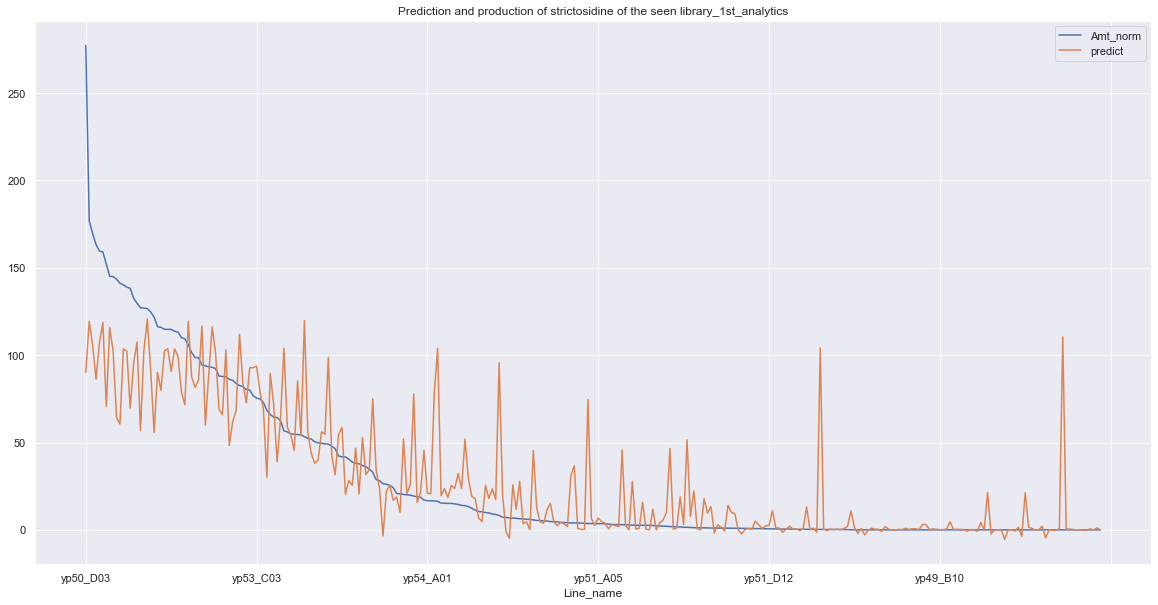

In [33]:
sns.set_context("paper", rc={"font.size":55,"axes.titlesize":5,"axes.labelsize":5}) 
sns.set(rc = {'figure.figsize':(30,10) })
df3.plot(y = ['Amt_norm','predict'], x =  'Line_name', figsize = (20,10))

ax = plt.gca()
ax.set_title("Prediction and production of strictosidine of the seen library_1st_analytics")

name = 'Prediction of the sampled library lineplot'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)

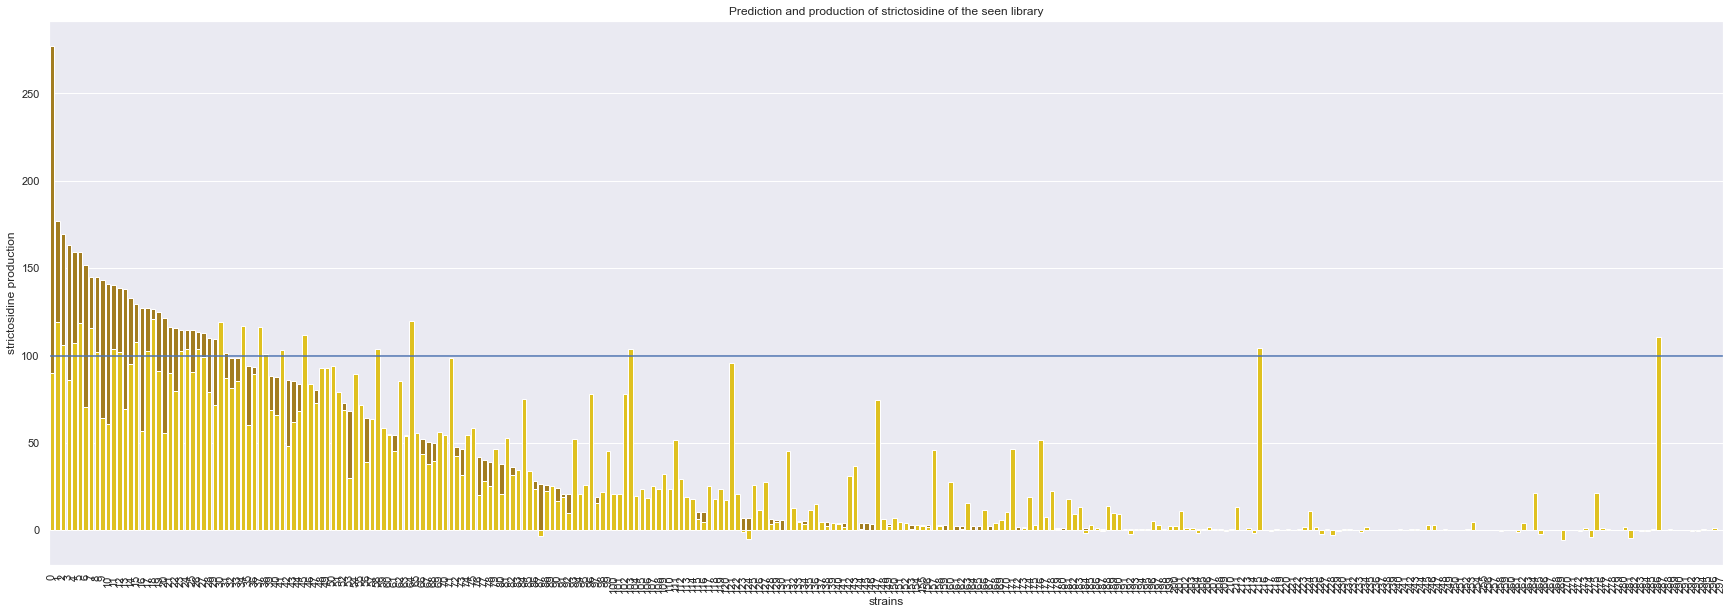

In [34]:
import matplotlib.pyplot as plt
sns.set_context("paper", rc={"font.size":55,"axes.titlesize":5,"axes.labelsize":5}) 
sns.set(rc = {'figure.figsize':(30,10) })


#creating subplots
ax=plt.subplots()
 
#plotting columns
ax=sns.barplot(x=df3.index,y=df3["Amt_norm"],color = 'darkgoldenrod')
ax=sns.barplot(x=df3.index,y=df3["predict"],color = 'gold')

 
#renaming the axes
ax.set(xlabel="strains", ylabel="strictosidine production")
plt.xticks(rotation=90)

ax = plt.gca()
ax.set_title("Prediction and production of strictosidine of the seen library")
ax.axhline(100)


name = 'Prediction of the sampled library_stacked_bar_1st_analytics"'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)


 
# visualizing illustration
plt.show()

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1347/3082259369.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds2['category'] = 'Predicted'
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1347/3082259369.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds1['category'] = 'Strictosidine'


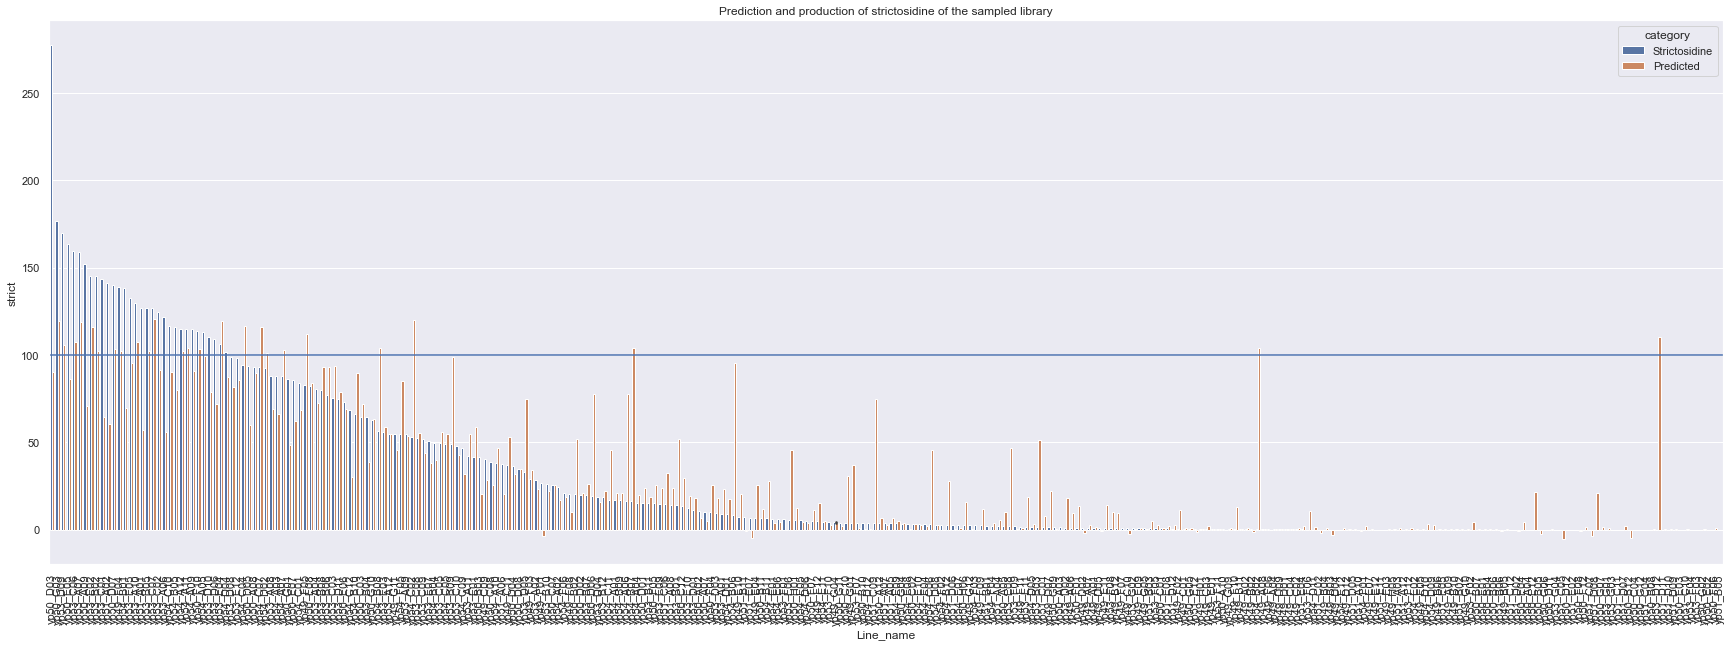

In [35]:
sns.set(rc = {'figure.figsize':(30,10) })


ds1 = df3[['Line_name', 'Amt_norm']]
ds1.columns = ['Line_name', 'strict']

ds2 = df3[['Line_name', 'predict']]
ds2.columns = ['Line_name', 'strict']


ds2['category'] = 'Predicted'
ds1['category'] = 'Strictosidine'
dss = pd.concat([ds1, ds2])

ax = sns.barplot(x='Line_name', y='strict', hue='category', data=dss)

ax = plt.gca()
ax.set_title("Prediction and production of strictosidine of the sampled library")
plt.xticks(rotation=90)
ax.axhline(100)
#ax.add_line
name = 'Prediction of the sampled library_1st_analytics"'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)


None


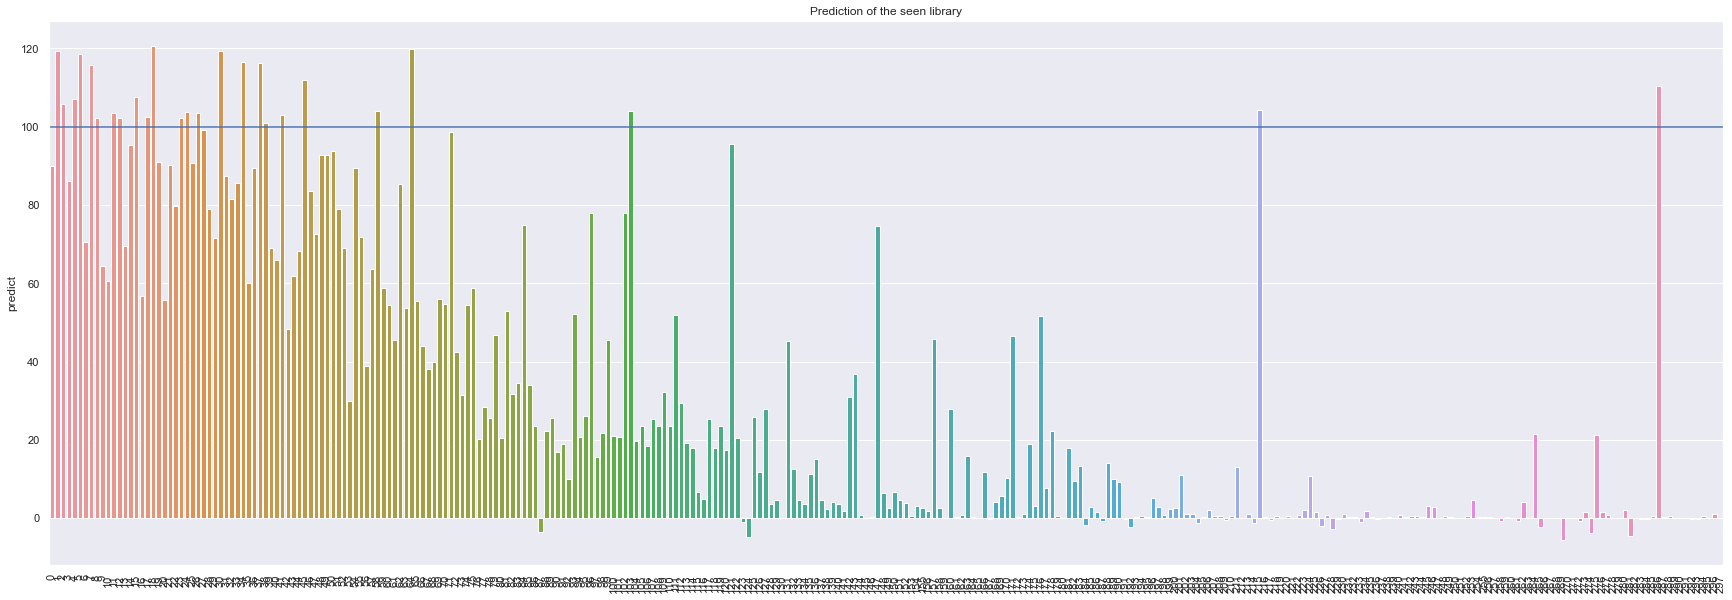

In [36]:
sns.set(rc = {'figure.figsize':(30,10) })

histogram = sns.barplot(data=df3, x=df3.index, y='predict')
histogram.axhline(100)
ax = plt.gca()
ax.set_title("Prediction of the seen library")

#plt.xticks(rotation=90)
histogram.set_xticklabels(histogram.get_xticklabels(), rotation=90)


name = 'Prediction of the sampled library_1st_analytics"'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)


# this makes sure the labels are not shown
None

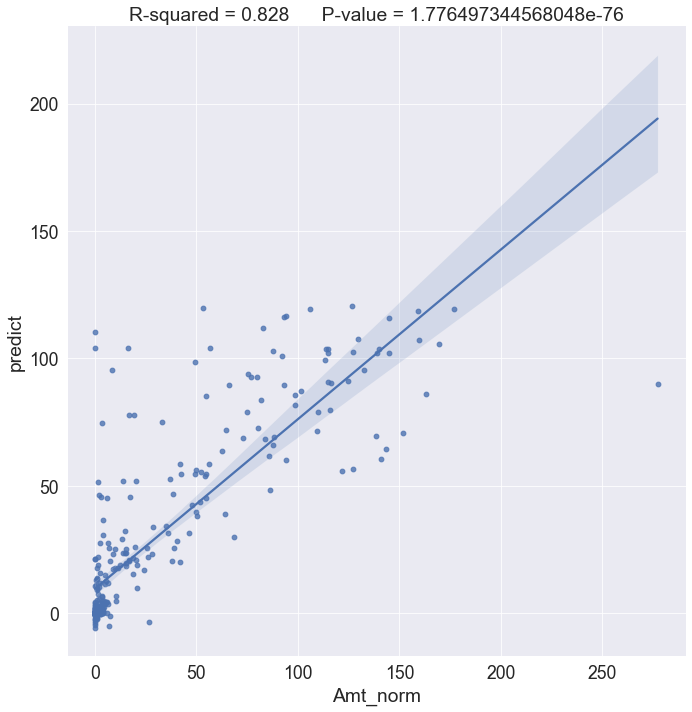

In [37]:
import seaborn as sns
from scipy.stats import pearsonr
import scipy as sp
from scipy import stats

#set seaborn plotting aesthetics as default
sns.set_context("paper", font_scale=2.0, rc={"lines.linewidth": 1.5})

g = sns.lmplot(data=df3, x="Amt_norm", y="predict",  palette="viridis", fit_reg = True, height=10)
r, p = stats.pearsonr(df3['Amt_norm'], df3['predict'])


ax = plt.gca()
ax.set_title(f"R-squared = {r:.3f}      P-value = {p}")

name = 'predicted_vs_amtnorm_corr_1st_analytics"'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)


None

### 4.2 Learning curve

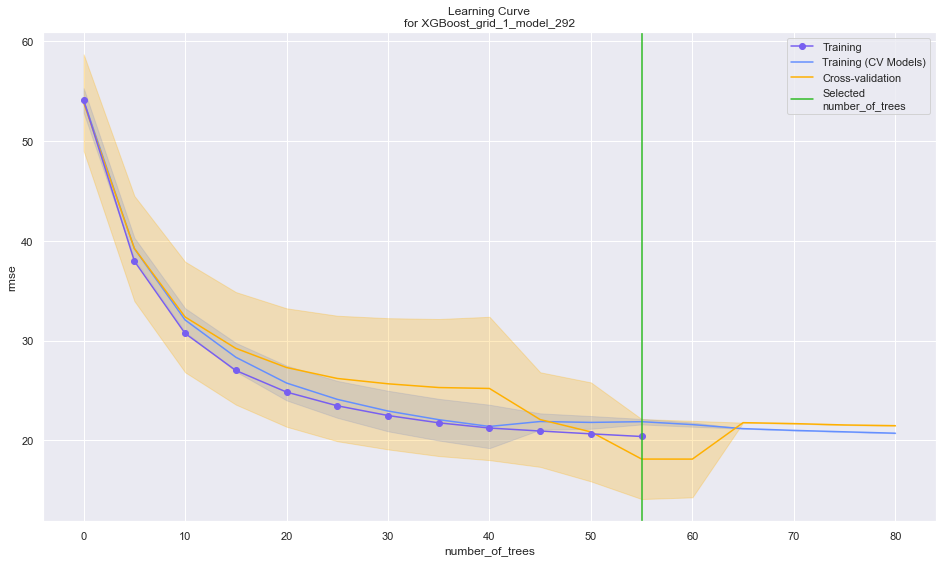

In [54]:

learning_curve = uploaded_model.learning_curve_plot()

name = '1st_analytics_learning_curve'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)


#plt.title('Number of records by State')
None

In [55]:
as_data_frame_df_test

,Line_name,0,1,2,3,Amt_norm
0,yp50_D03,5,2,6,3,277.307816
1,yp49_F04,3,2,6,2,138.940568
2,yp53_E02,6,2,6,5,145.152656
3,yp53_A07,5,2,6,2,159.059724
4,yp53_C07,6,2,6,4,126.638026
...,...,...,...,...,...,...
293,yp54_D09,5,1,6,6,0.000000
294,yp54_D10,5,1,6,6,0.000000
295,yp49_E05,2,3,7,8,0.000000
296,yp54_E02,6,1,6,6,0.000000


### 4.3 Find predicted genotypes

In [40]:
import numpy as np

In [41]:
all_genotypes = pd.read_csv('ConStrain_on_google_colab/Data/processed/remaining_genotypes_after_first_iteration.csv',)
all_genotypes =all_genotypes[['0','1','2','3']]
all_genotypes

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [42]:
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))
all_genotypes_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


0,1,2,3
1,1,5,1
1,1,5,2
1,1,5,4
1,1,5,5
1,1,5,7
1,1,5,8
1,1,5,9
1,1,6,1
1,1,6,2
1,1,6,3


In [43]:
#merge_ = pd.merge(new_input_for_ml,all_genotypes, on= ['0','1','2','3'])
#merge_
new_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/processed/input_for_ml_2nd_iteration.csv',  index_col=False)

input_fixed = new_input_for_ml[['0','1','2','3']]
input_fixed

,0,1,2,3
0,4,1,5,2
1,4,1,5,2
2,4,2,5,2
3,5,1,5,2
4,5,1,5,2
...,...,...,...,...
122,7,2,5,7
123,7,2,5,7
124,7,2,6,7
125,4,2,5,2


### 4.4 Getting rid of the genotypes we have already tested:

In [44]:
df_diff = all_genotypes[~all_genotypes.apply(tuple,1).isin(input_fixed.apply(tuple,1))]
#df_diff.to_csv('../data/processed/remaining_genotypes_after_first_iteration.csv')
df_diff

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [45]:
# make the diff into a df 
all_genotypes_df = h2o.H2OFrame(pd.concat([df_diff], axis='columns'))
all_genotypes_df['0']= all_genotypes_df['0'].asfactor()
all_genotypes_df['1']= all_genotypes_df['1'].asfactor()
all_genotypes_df['2'] = all_genotypes_df['2'].asfactor()
all_genotypes_df['3'] = all_genotypes_df['3'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [46]:
predicted = best_model.predict(all_genotypes_df)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [47]:
len(predicted)

1049

In [48]:
predicted_norm = predicted.as_data_frame()
predicted_norm.head()

,predict
0,1.562470
1,1.605791
2,2.738774
3,1.221787
4,0.304300


In [49]:
# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
df_diff['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = df_diff.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1347/105107836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['predicted_norm_strict'] = predicted_list


,0,1,2,3,predicted_norm_strict
614,5,2,6,8,127.463974
610,5,2,6,4,126.780907
605,5,2,5,8,123.568245
600,5,2,5,2,120.990326
602,5,2,5,4,120.404465
...,...,...,...,...,...
9,1,1,6,3,-4.840076
866,7,1,7,5,-5.105438
993,8,1,6,1,-6.158859
995,8,1,6,3,-6.167753


If we want the names on the genotypes we can do the following: 

In [50]:
g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

## 5. Top 20 predicted producers

In [51]:
df_with_genotypes = pd.DataFrame(list_of_lists )
df_with_genotypes = df_with_genotypes.T
df_with_genotypes.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
df_with_genotypes.head(20)

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Cac,127.463974
1,Smus,ENO2,TPI1,Clo,126.780907
2,Smus,ENO2,CCW12,Cac,123.568245
3,Smus,ENO2,CCW12,Aan,120.990326
4,Smus,ENO2,CCW12,Clo,120.404465
5,Smus,ENO2,CCW12,Ara,120.144058
6,Rsep,ENO2,TPI1,Cac,120.002716
7,Rsep,ENO2,TPI1,Aan,119.287704
8,Rsep,ENO2,CCW12,Rse,116.394524
9,Rsep,ENO2,CCW12,Cac,116.26902


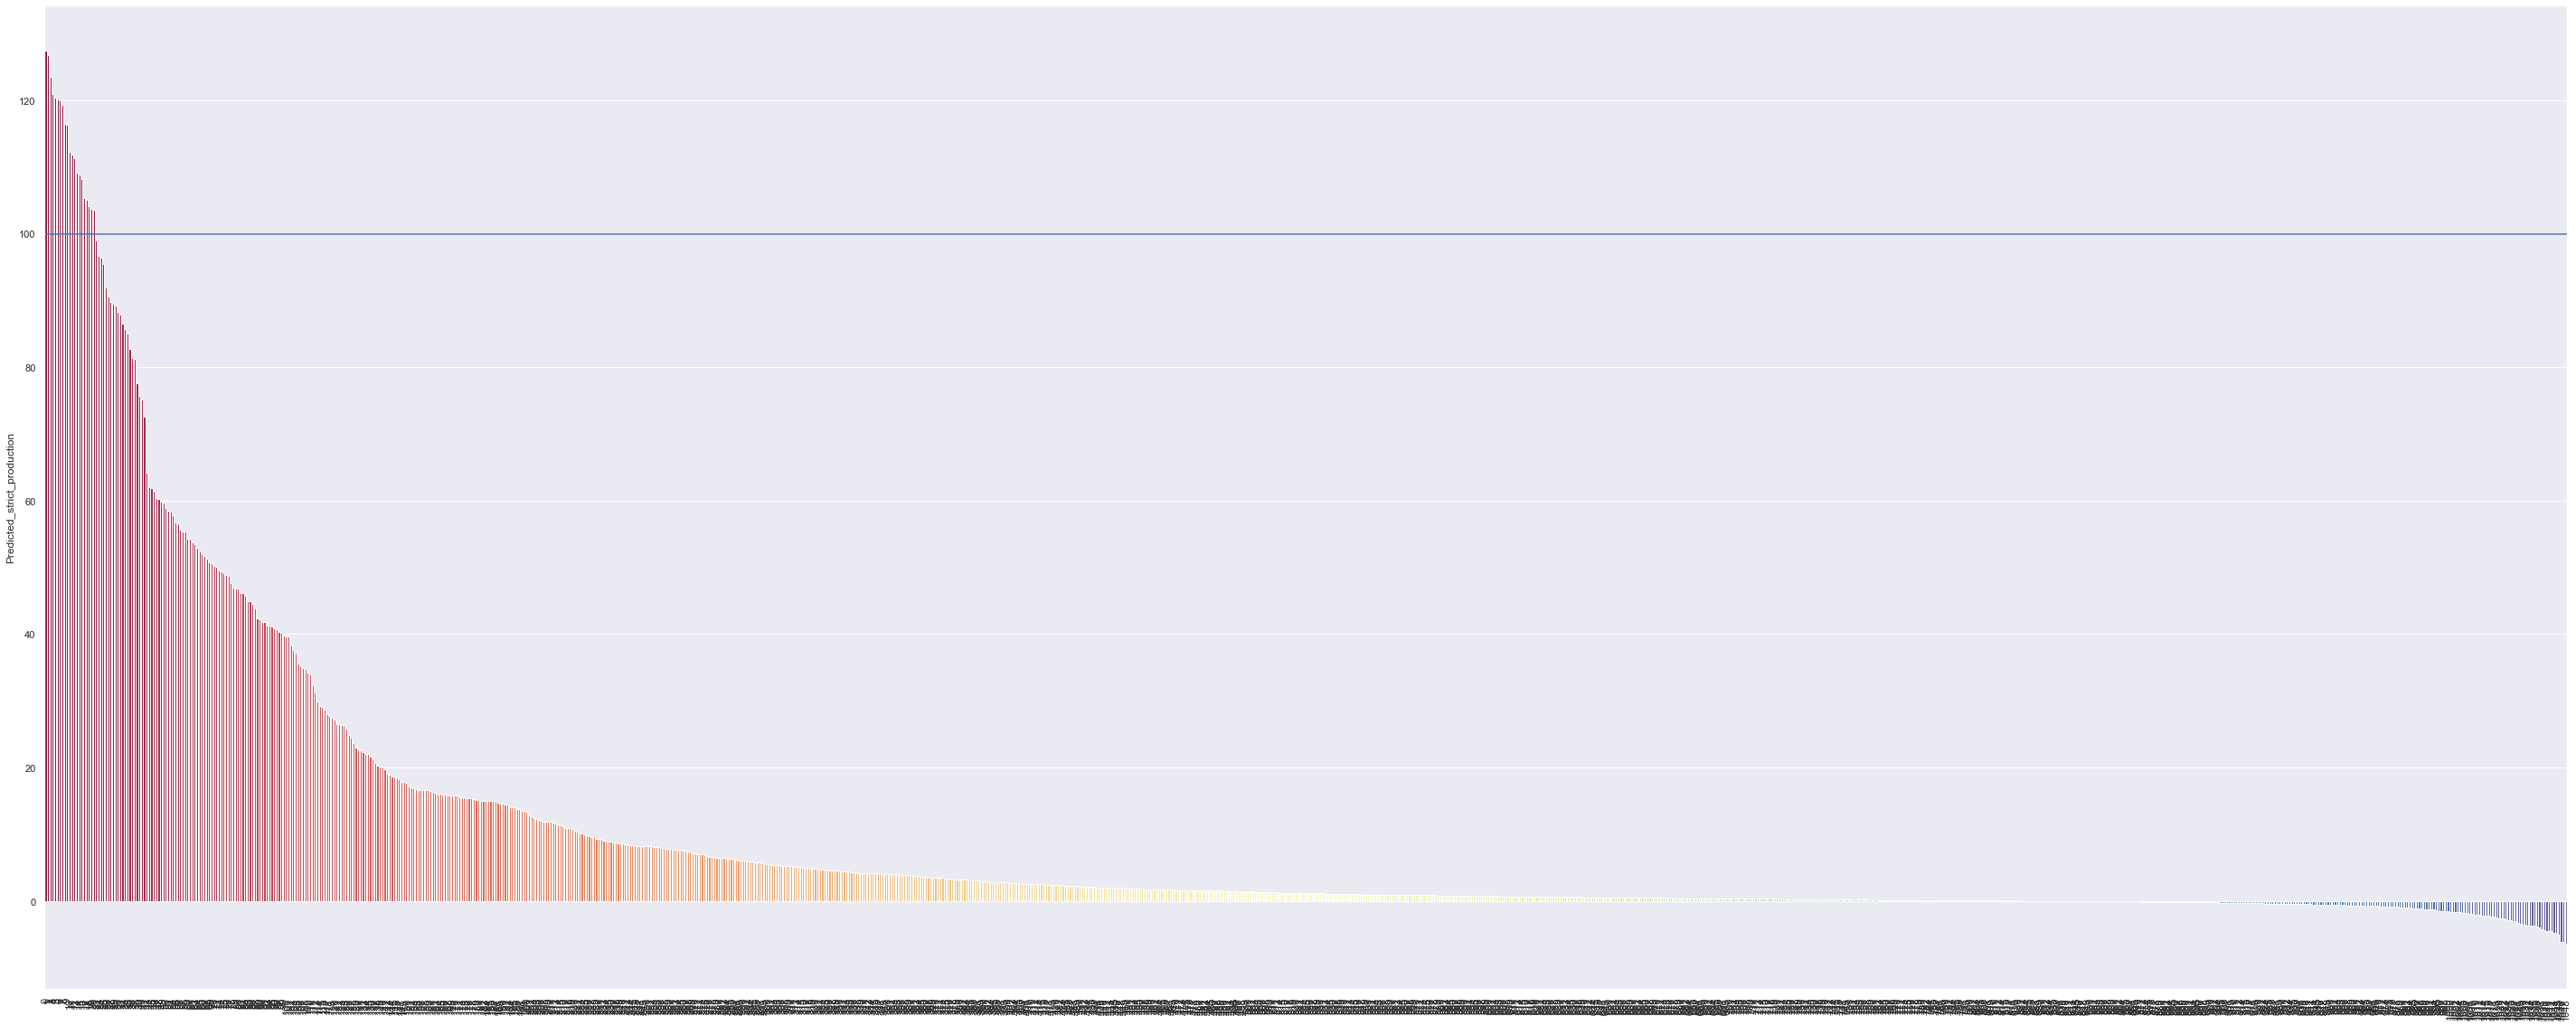

In [52]:
sns.set(rc = {'figure.figsize':(50,20) })

histogram = sns.barplot(data=df_with_genotypes, x=df_with_genotypes.index, y='Predicted_strict_production', palette= "Spectral")

histogram.axhline(100)

histogram.set_xticklabels(histogram.get_xticklabels(), rotation=90)

name = 'Predicted strict production of all unseen genotype_1st_analytics'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)

# this makes sure the labels are not shown
None

In [53]:
df_with_genotypes.to_csv('ConStrain_on_google_colab/Data/AutoML/top20_ML_predicted_after_second_DBTL_1st_analytics.csv', index=False)